In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque, namedtuple
from torch.distributions import Categorical
import matplotlib.animation as animation
import gymnasium as gym
from tqdm import tqdm
import time

In [2]:
class Actor(nn.Module):
    """ Given a state, return the probability of each action. """
    def __init__(self, state_dim=1, action_dim=4, hidden_dim=8):
        """ Initialize an Actor object.

        Params
        ======
            state_dim (int): vector dimension of state vector.
            action_dim (int): number of actions.
            fc1_dim (int): number of units in the first hidden layer.
            fc2_dim (int): number of units in the second hidden layer.
        """
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        """ Given a state, return probability of each action.

        Params
        ======
            x (torch.Tensor): the state tensor of shape [batch_size, state_dim]
        """ 
        
        x = F.relu(self.fc1(x)) # [batch_size, hidden_dim]
        return F.softmax(self.fc2(x), dim=1) # [batch_size, action_dim]

In [3]:
class Critic(nn.Module):
    """ Given a state, return the probability on each support of each action """
    
    def __init__(self, state_dim=1, action_dim=4, n_support=51, hidden_dim=8):
        """ Initialize a Critic object.

        Params
        ======
            state_dim (int):
            action_dim (int):
            n_support (int): number of supports
            fc1_dim (int):
            fc2_dim (int):
        """
        
        super(Critic, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.n_support = n_support
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim * n_support)

    def forward(self, x):
        """ 
        Params
        ======
            x: state # [batch_size, state_dim]
        """
        x = F.relu(self.fc1(x)) # [batch_size, hidden_dim]
        x = self.fc2(x).view(-1, self.action_dim, self.n_support) # [batch_size, action_dim, n_support]
        return F.softmax(x, dim=2) # [batch_size, action_dim, n_support]

In [18]:
class DistributionalActorCriticAgent:
    def __init__(self, state_dim=1, action_dim=4, hidden_dim=8, # Neural Networks
                 n_support=31, vmin=-300, vmax=0, gamma=0.99, # Categorical Distribution
                 actor_lr=1e-3, critic_lr=1e-3, n_actor=500, n_critic=500, max_t=300, alpha=0.95, # Learning
                 print_every=2, patience=10, seed=0): # others

        """
        state_dim: Dimension of state space
        action_dim: Dimension of action space
        hidden_dim: Dimension of Hidden layer
        
        n_support: Number of supports
        vmin: Mimimum of categorical distribution
        vmax: Maximum of categorical distribution
        gamma: discounted factor
        
        actor_lr: Learning rate for actor network
        critic_lr: Learning rate for critic network
        max_t: Maximum length of one trajectory
        alpha: Risk Averse Coefficient
        
        print_every: Logging Frequency
        critic_eps: Param for early stopping (Critic Network Tolerance)
        patience: Param for early stopping
        """
        
        #### Learning
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.actor_network = Actor(state_dim, action_dim, hidden_dim).to(self.device)
        self.critic_network = Critic(state_dim, action_dim, n_support, hidden_dim).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor_network.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic_network.parameters(), lr=critic_lr)
        self.n_actor = n_actor
        self.n_critic = n_critic
        
        self.max_t = max_t
        self.alpha = alpha


        # Categorical Distribution
        self.n_support = n_support
        self.vmin = vmin
        self.vmax = vmax
        self.supports = torch.linspace(self.vmin, self.vmax, n_support)  # (N,)
        self.dz = (self.vmax - self.vmin) / (self.n_support - 1)
        self.gamma = gamma        

        #### Logging & Early Stopping
        self.print_every = print_every
        self.patience = patience
        self.seed = seed


        # loss functions
        self.mse = nn.MSELoss()
        self.kl_div = nn.KLDivLoss(reduction='batchmean')


    # verified; no requirement for batches
    def act(self, state):
        """ Given a state vector, return an action randomly.
        params
        ======
            state (np.ndarray): the vector that represents a state.

        Returns
        ======
            A random action given input state.
        """
        state = torch.from_numpy(state).unsqueeze(0).float().to(self.device) # (1, state_dim])
        probs = self.actor_network(state).squeeze(0).float().cpu() # (action_dim, )
        m = Categorical(probs) # Categorical Distribution
        action = m.sample() # sample an action from categorical distribution
        return action.item()


    ###################################### Compute Eta Gradient ######################################
    def g_no_grad(self, state):
        """ Compute the g(s) without gradient of policy
        
        Params
        ======
            state (np.ndarray): of shape (state_dim, )

        Returns
        ======
            g(s) = \sum_{a \in \calA} \nabla_{\theta}\pi(a|s)\eta_N^{(s, a)}
        """
        state = torch.from_numpy(state).unsqueeze(0).float().to(self.device) # (1, state_dim), GPU
        action_probs = self.actor_network(state) # (1, action_dim), GPU
        value_dists = self.critic_network(state) # (1, action_dim, n_support), GPU
        return (action_probs.unsqueeze(-1) * value_dists.detach()).sum(dim=1).squeeze(0).cpu() # (n_support,), CPU



    def projected_pushforward_once_(self, reward, dist, done):
        """ Given a reward, project and pushforward the distribution.

        Params
        ======
            reward (float): rewards of shape (batch_size, 1)
            dist (torch.Tensor): probability distribution of shape (self.n_support, ) 1-d tensor
            dones (bool): terminal status

        Returns
        ======
            Return a reshaped probability distribution of shape (batch_size, self.n_support)
        
        """
        new_dist = torch.zeros_like(dist) # (n_support, )

        # if it's a terminal status -> find position of reward and update
        if done:
            b = (reward - self.vmin) / self.dz
            l = int(np.floor(b))
            u = int(np.ceil(b))
            
            if l == u:
                # In this case, b is an integer -> update once
                new_dist[l] = 1.0

            else:
                # update twice
                new_dist[l] = u - b
                new_dist[u] = b - l

        else:
            shifted_supports = reward + self.gamma * self.supports # (n_support, )
            for j in range(self.n_support):
                if shifted_supports[j] < self.vmin:
                    new_dist[0] += dist[j]
                
                elif shifted_supports[j] > self.vmax:
                    new_dist[-1] += dist[j]
                
                else:
                    b = (shifted_supports[j] - self.vmin) / self.dz
                    l = int(np.floor(b))
                    u = int(np.ceil(b))
                    
                    new_dist[l] += dist[j] * (u + (l == u) - b) # incase b is an integer, b = u = l
                    new_dist[u] += dist[j] * (b - l)

        return new_dist # (n_support, )
            
           


    
    def projected_pushforward(self, trajectory, dist):
        """ Repeatedly compute the projected pushforward distribution along a trajectory backwardly.

        Params
        ======
            trajectory (List): [s_1_0, a_1_0, r_1_0, d_1_0, ..., s_1_T, a_1_T, r_1_T, d_1_T]
            dist (torch.Tensor(1, n_support)): input measure distribution

        Returns
        ======
           Return the reshaped distributions.
        """
        
        rewards = np.array(trajectory[2::4])
        
        dones = np.array(trajectory[3::4])

        length = int(len(rewards))
        
        for i in range(length):
            reward = rewards[-(i+1)]
            done = dones[-(i+1)]
            dist = self.projected_pushforward_once_(reward, dist, done)
        
        return dist # (n_support, )


    # verified
    def eta_no_grad(self, trajectory):
        """ Given a trajectory, compute eta(state) -> refer to C.7 Proof of Theorem 5

        Params
        ======
            trajectory (List[List]): [s_0, a_0, r_0, d_0, ..., s_T, a_T, r_T, d_T]
            dist (torch.Tensor(1, n_support)): input measure distribution

        Returns
        ======
           Return the reshaped distributions.
        """
        res = 0
        
        for i in range(len(trajectory) // 4):
            sub_trajectory = trajectory[:4*i+1]
            res += self.projected_pushforward(sub_trajectory[:-1], self.g_no_grad(sub_trajectory[-1]))
        
        return res

    ###################################### Compute Eta Gradient ######################################




    
    ###################################### Train Critic Network #####################################
    def train_critic(self, env):
        """
        n_critic: number of trajectories to generate to train the critic network
        max_t: maximum trajectory length
        """

        # Begin training
        avg_loss = 0
        patience_count = 0
        best_loss = float('inf')
        num_traj = 0
        start_time = time.time()
        
        for i_critic in range(self.n_critic):
            num_traj += 1
            states_list   = []
            actions_list  = []
            td_targets_list = []
            
            state, _ = env.reset()
            if isinstance(state, int):
                state = np.array([state])
            
            for t in range(self.max_t):
                action = self.act(state)
                next_state, reward, done, _, _ = env.step(action)
                if isinstance(next_state, int):
                    next_state = np.array([next_state])
    
                next_action = self.act(next_state)
    
                with torch.no_grad():
                    # dist_next: shape (n_support,)
                    dist_next = self.critic_network(
                        torch.from_numpy(next_state).to(self.device).unsqueeze(0).float()
                    ).cpu().squeeze(0)[next_action]
                    
                    td_target = self.projected_pushforward_once_(-reward, dist_next, done) 
                    # td_target: shape (n_support, )
    
                states_list.append(state)
                actions_list.append(action)
                td_targets_list.append(td_target)
    
                if done:
                    break
                
                state = next_state

            states_tensor = torch.from_numpy(np.array(states_list)).float().to(self.device)
            actions_tensor = torch.tensor(actions_list, dtype=torch.long)
            
            td_targets_tensor = torch.stack(td_targets_list, dim=0)
    
            predictions_batch = self.critic_network(states_tensor).cpu()
            
            batch_size = predictions_batch.size(0)  # trajectory_len
            idx = torch.arange(batch_size)
            selected_predictions = predictions_batch[idx, actions_tensor]
    
            critic_loss = self.kl_div(selected_predictions.log(), td_targets_tensor)

            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
    
            total_loss = critic_loss.item()
    
            avg_loss = 1 / (i_critic + 1) * total_loss + i_critic / (i_critic + 1) * avg_loss
            
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_count = 0
            
            else:
                patience_count += 1
    
            if patience_count >= self.patience:
                print(f"Early Stopping Triggered at trajectory {i_critic} due to no improvement!")
                break
    ###################################### Train Critic Network ######################################
        end_time = time.time()
        return num_traj, end_time-start_time





    ###################################### Compute CVaR Loss ######################################
    def state_value_distribution_(self, state):
        """
        :params state [float]
        :returns Probability Distribution on N supports -> torch.Tensor(N)
        """
        state = torch.from_numpy(state).unsqueeze(0).float().to(self.device) # (1, state_dim)
        
        with torch.no_grad():
            probs = self.actor_network(state) # (1, action_dim)
            dist = self.critic_network(state) # (1, action_dim, n_support)
            return (probs.unsqueeze(-1) * dist).sum(dim=1).squeeze(0).cpu() # (n_support, )

    
    def q_alpha_(self, state):
        """
        Compute (1-\alpha)-quantile using categorical distribution
        """
        dist = self.state_value_distribution_(state) # (n_support, ), CPU
        tail = dist.cumsum(axis=0) >= (1 - self.alpha - 1e-2) # (n_support, )
        tail_supports = self.supports[tail] # (< n_support, )
        return tail_supports[0].item() # float


    def CVaR_loss(self, state, eta_no_grad):
        """ eta_no_grad contains only actor gradient information
        """
        q_alpha = self.q_alpha_(state)
        return (eta_no_grad * (self.supports - q_alpha) * torch.where(self.supports > q_alpha, 1.0, 0.0)).sum()
    ###################################### Compute CVaR Loss ######################################

    
    def test(self, env):
        state, _ = env.reset(seed=self.seed)
        if isinstance(state, int):
            state = np.array([state])
        
        score = 0
        for t in range(self.max_t):
            action = self.act(state)
            next_state, reward, done, _, _ = env.step(action)
            if isinstance(next_state, int):
                next_state = np.array([next_state])
            
            score += reward

            if done:
                break
            
            state = next_state
        return score

    def train(self, env):
        init_score = self.test(env)
        scores_deque = deque(maxlen=5)
        scores_deque.append(init_score)
        scores = [init_score]
        time_count = [0.]
        traj_count = [0]

        ### Start Training
        for i_actor in range(self.n_actor):
            if i_actor % self.print_every == 0:
                print(f'Episode {i_actor}\tAverage Score: {np.mean(scores_deque):.2f}')
            
            # First, train the critic network
            n_traj, critic_time = self.train_critic(env)

            # Collect one trajectory
            trajectory = []
            state, _ = env.reset(seed=self.seed)
            if isinstance(state, int):
                state = np.array([state])
            for t in range(self.max_t):
                action = self.act(state)
                next_state, reward, done, _, _ = env.step(action)
                if isinstance(next_state, int):
                    next_state = np.array([next_state])
                # Collect the trajectory
                trajectory.append(state)
                trajectory.append(action)
                trajectory.append(-reward)
                trajectory.append(done)
                if done:
                    break
                state = next_state

            # Update Actor Network
            start_time = time.time()
            eta = self.eta_no_grad(trajectory)
            actor_loss = self.CVaR_loss(trajectory[0], eta)
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            end_time = time.time()

            # Test One Episode
            score = self.test(env)
            scores.append(score)
            scores_deque.append(score)
            
            n_traj += 1
            total_time = end_time - start_time + critic_time
            time_count.append(total_time)
            traj_count.append(n_traj)


            if np.mean(scores_deque) >= 1000.0:
                print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_actor-5, np.mean(scores_deque)))
                break
        
        return np.array(scores), np.array(time_count), np.array(traj_count)

In [19]:
env = gym.make('CartPole-v1')

In [20]:
# Initialization Networks
DACA_Base = DistributionalActorCriticAgent(state_dim=4, action_dim=2, hidden_dim=8,
                                         n_support=31, vmin=-300, vmax=0, gamma=0.99,
                                         actor_lr=1e-2, critic_lr=1e-2, n_actor=200, n_critic=200, max_t=300, alpha=0.9,
                                         print_every=1, patience=500)

In [ ]:
DACA = DistributionalActorCriticAgent(state_dim=4, action_dim=2, hidden_dim=8,
                                         n_support=31, vmin=-300, vmax=0, gamma=0.99,
                                         actor_lr=1e-2, critic_lr=1e-2, n_actor=110, n_critic=200, max_t=300, alpha=0.9,
                                         print_every=1, patience=500)

DACA.actor_network.load_state_dict(DACA_Base.actor_network.state_dict())
DACA.critic_network.load_state_dict(DACA_Base.critic_network.state_dict())
DACA.train(env)

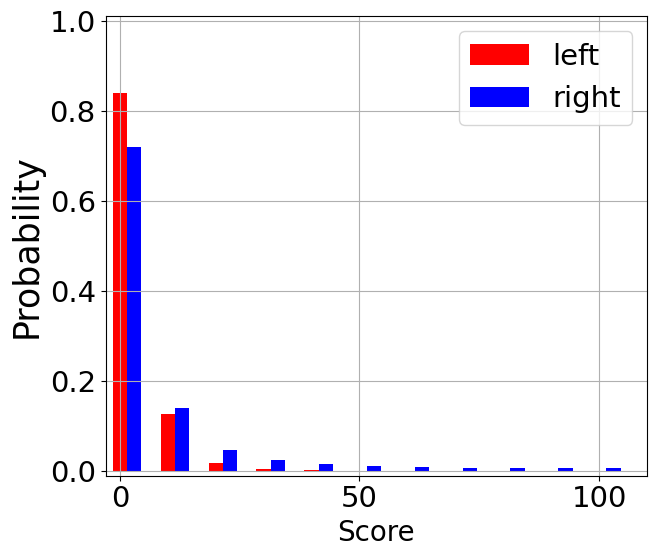

In [125]:
plt.rc('font', size=21)
plt.figure(figsize=(7, 6))

plt.bar(np.linspace(0, 300, 31), value_dist[0].flatten()[::-1],  color='red', width=3, label='left') # action = 0 (left)
plt.bar(np.linspace(0, 300, 31) + 3, value_dist[1].flatten()[::-1],  color='blue', width=3, label='right') # action = 1 (right)


plt.ylim(-0.01, 1.01)
plt.yticks([0, 0.2, 0.4 ,0.6, 0.8, 1.0])
plt.ylabel('Probability', fontsize=25)

plt.xlim(-3, 110)
plt.xticks([0, 50, 100])
plt.xlabel('Score', fontsize=20)

plt.grid()
plt.legend(loc=0)
plt.tight_layout()
